In [1]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# === Cell 1 (SUBMISSION VERSION): imports and paths, no Colab ===

from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Root of the project (where the notebook is)
PROJECT_ROOT = Path(".")

# Dataset root (your TA will place the dataset here)
DATASET_ROOT = PROJECT_ROOT / "Jigsaw Puzzle Dataset" / "Gravity Falls"

# Folders of puzzle pieces
PUZZLE_FOLDERS = [
    "puzzle_2x2",
    "puzzle_4x4",
    "puzzle_8x8",
]

# Output directories for processed images
OUTPUT_ROOT = PROJECT_ROOT / "processed_images"
ENHANCED_DIR = OUTPUT_ROOT / "enhanced"
MASK_DIR = OUTPUT_ROOT / "masks"

os.makedirs(ENHANCED_DIR, exist_ok=True)
os.makedirs(MASK_DIR, exist_ok=True)

print("Dataset root:", DATASET_ROOT)
print("Enhanced output:", ENHANCED_DIR)
print("Masks output:", MASK_DIR)




Dataset root: Jigsaw Puzzle Dataset\Gravity Falls
Enhanced output: processed_images\enhanced
Masks output: processed_images\masks


Using sample image: Jigsaw Puzzle Dataset\Gravity Falls\puzzle_2x2\0.jpg


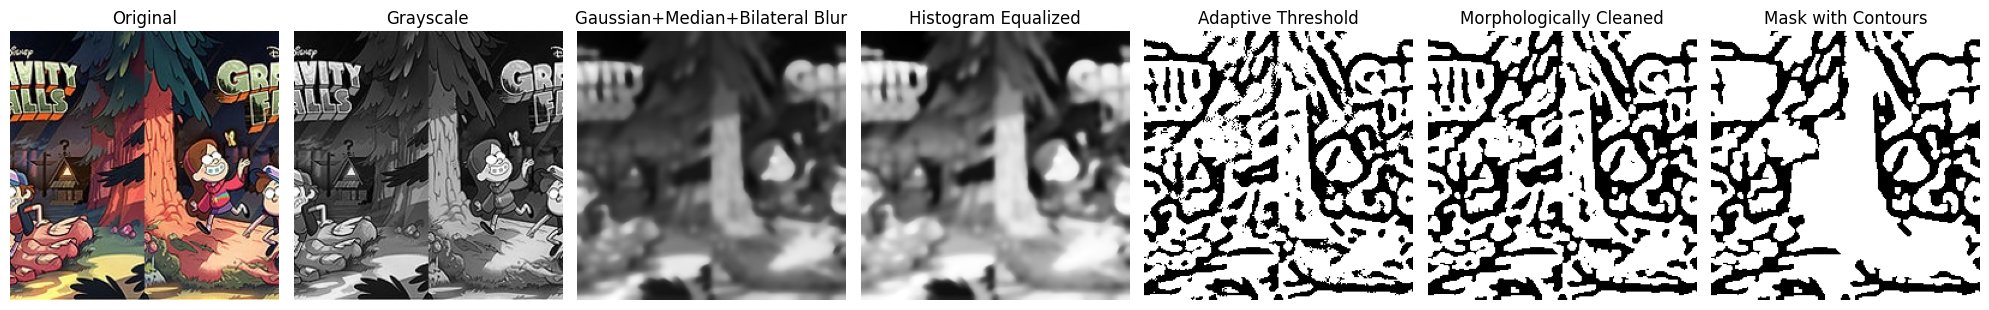

In [3]:
# === Cell 2: Single-image demonstration pipeline (for report visuals) ===

# Pick the first image from the 2x2 folder
sample_folder = DATASET_ROOT / "puzzle_2x2"
sample_paths = sorted(sample_folder.glob("*.jpg"))

if not sample_paths:
    raise FileNotFoundError(f"No .jpg images found in {sample_folder}")

sample_img_path = sample_paths[0]
print("Using sample image:", sample_img_path)

img = cv2.imread(str(sample_img_path))
if img is None:
    raise ValueError(f"Failed to load image: {sample_img_path}")

# --- Step 1: Grayscale ---
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# --- Step 2: Blurring (Gaussian + Median + Bilateral) ---
g_blur = cv2.GaussianBlur(gray, (5, 5), 0)
m_blur = cv2.medianBlur(g_blur, 5)
b_blur = cv2.bilateralFilter(m_blur, 9, 75, 75)

# --- Step 3: Histogram Equalization ---
hist_eq = cv2.equalizeHist(b_blur)

# --- Step 4: Thresholding (Otsu + Adaptive, we use Adaptive) ---
_, otsu_thresh = cv2.threshold(
    hist_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
adapt_thresh = cv2.adaptiveThreshold(
    hist_eq, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY, 11, 2
)
final_thresh = adapt_thresh

# --- Step 5: Morphological Cleaning ---
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
clean = cv2.morphologyEx(final_thresh, cv2.MORPH_OPEN, kernel)

# --- Step 6: Contour Extraction + Mask Generation ---
contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(gray)
cv2.drawContours(mask, contours, -1, 255, -1)  # white pieces on black

# --- Visualize all stages side by side ---
stages = [
    ("Original", cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),
    ("Grayscale", gray),
    ("Gaussian+Median+Bilateral Blur", b_blur),
    ("Histogram Equalized", hist_eq),
    ("Adaptive Threshold", final_thresh),
    ("Morphologically Cleaned", clean),
    ("Mask with Contours", mask),
]

plt.figure(figsize=(20, 5))
for i, (title, stage_img) in enumerate(stages, start=1):
    plt.subplot(1, len(stages), i)
    if len(stage_img.shape) == 2:
        plt.imshow(stage_img, cmap="gray")
    else:
        plt.imshow(stage_img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
# === Cell 3: Reusable pipeline + batch processing for all images ===

def process_image(img_path: str):
    """
    Load an image, apply the enhancement pipeline,
    and return (clean_binary_image, mask).
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to load image: {img_path}")

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur (Gaussian + Median + Bilateral)
    g_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    m_blur = cv2.medianBlur(g_blur, 5)
    b_blur = cv2.bilateralFilter(m_blur, 9, 75, 75)

    # Histogram Equalization
    hist_eq = cv2.equalizeHist(b_blur)

    # Adaptive Thresholding
    final_thresh = cv2.adaptiveThreshold(
        hist_eq, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    # Morphological Cleaning
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    clean = cv2.morphologyEx(final_thresh, cv2.MORPH_OPEN, kernel)

    # Contour-based Mask
    mask = np.zeros_like(gray)
    contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, contours, -1, 255, -1)

    return clean, mask

# --- Loop through all folders & images, save enhanced + mask ---
for folder in PUZZLE_FOLDERS:
    folder_path = DATASET_ROOT / folder
    img_paths = sorted(folder_path.glob("*.jpg"))+ list(folder_path.glob("*.png"))

    if not img_paths:
        print(f"[WARNING] No images found in {folder_path}")
        continue

    print(f"Processing folder: {folder} ({len(img_paths)} images)")
    for img_path in img_paths:
        enhanced, mask = process_image(str(img_path))
        img_name = img_path.name

        cv2.imwrite(str(ENHANCED_DIR / f"{folder}_{img_name}"), enhanced)
        cv2.imwrite(str(MASK_DIR / f"{folder}_{img_name}"), mask)

print("✅ All images processed and saved!")
print("Enhanced images:", ENHANCED_DIR)
print("Masks:", MASK_DIR)


Processing folder: puzzle_2x2 (110 images)
Processing folder: puzzle_4x4 (110 images)
Processing folder: puzzle_8x8 (110 images)
✅ All images processed and saved!
Enhanced images: processed_images\enhanced
Masks: processed_images\masks



=== Previewing folder: puzzle_2x2 ===


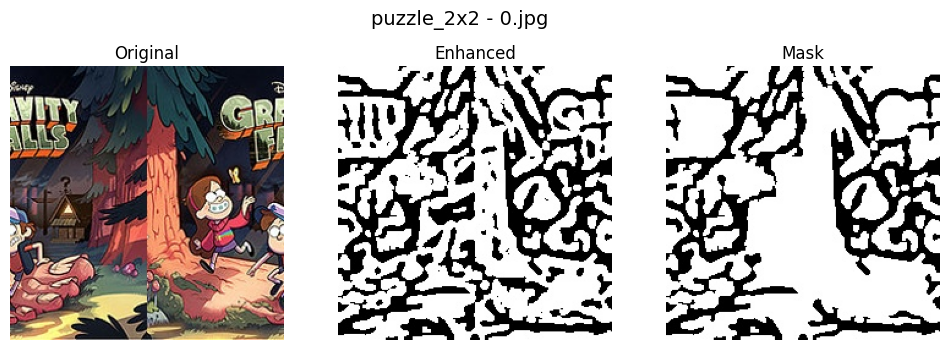

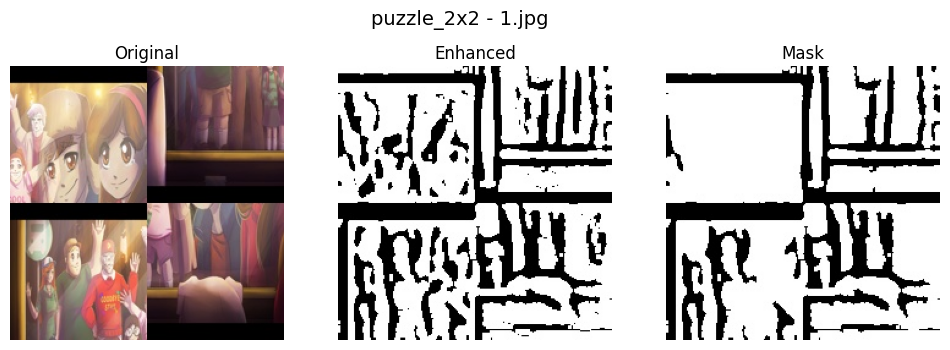

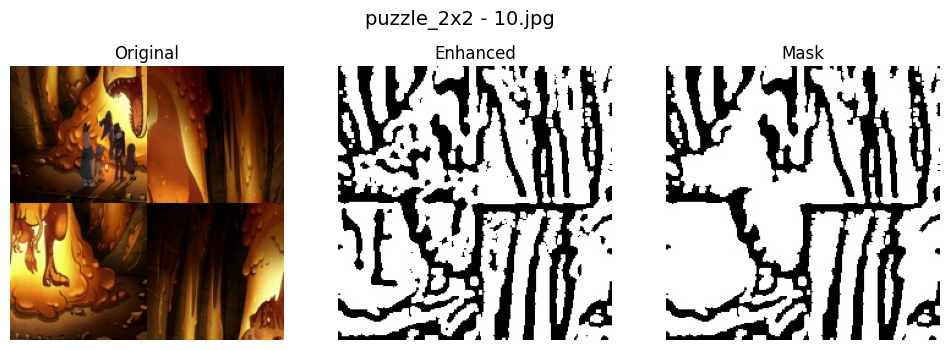


=== Previewing folder: puzzle_4x4 ===


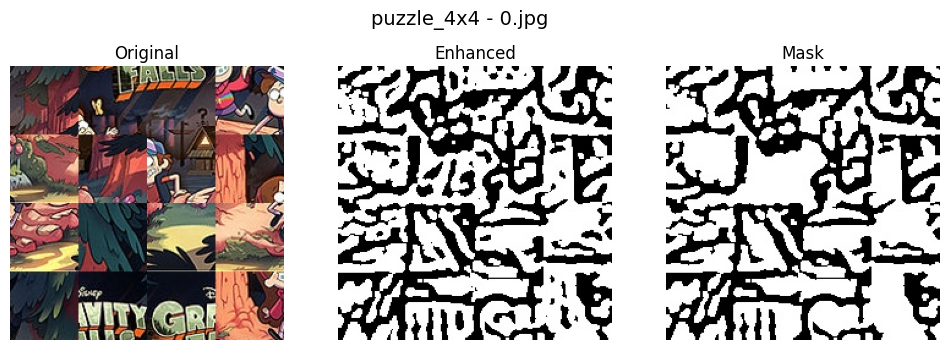

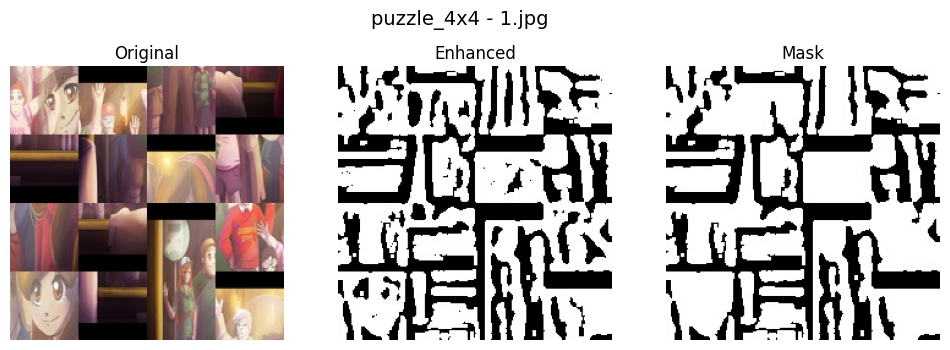

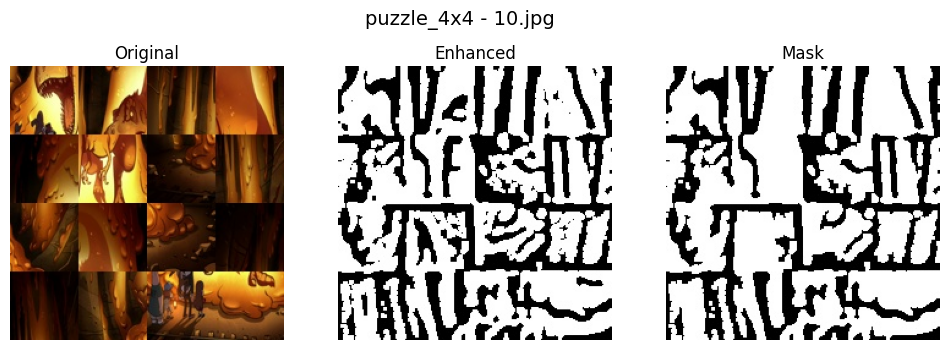


=== Previewing folder: puzzle_8x8 ===


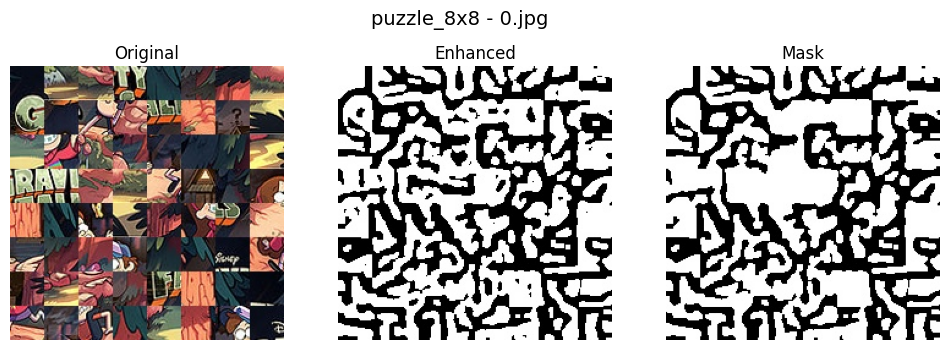

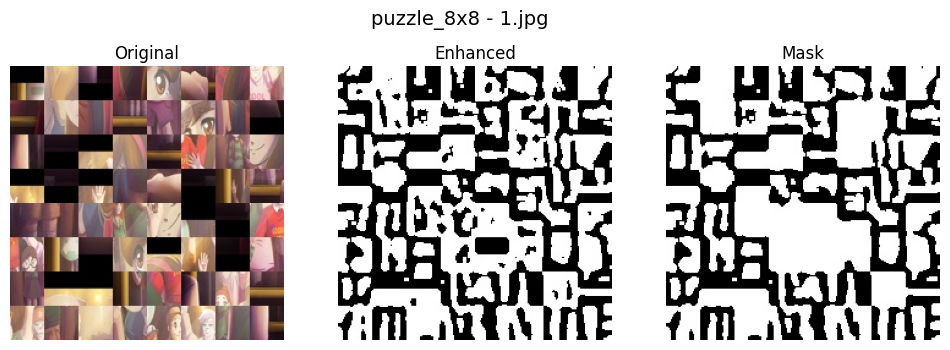

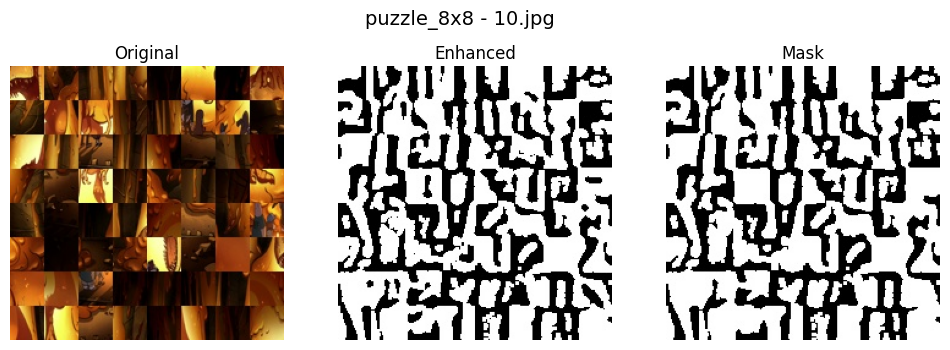

In [5]:
# === Cell 4: Preview Original vs Enhanced vs Mask ===

def preview_images(folder_name: str, num_images: int = 3):
    folder_path = DATASET_ROOT / folder_name
    img_paths = sorted(folder_path.glob("*.jpg"))[:num_images]

    if not img_paths:
        print(f"[WARNING] No images to preview in {folder_path}")
        return

    for img_path in img_paths:
        img_name = img_path.name

        enhanced_path = ENHANCED_DIR / f"{folder_name}_{img_name}"
        mask_path = MASK_DIR / f"{folder_name}_{img_name}"

        original = cv2.imread(str(img_path))
        if original is None:
            print(f"[WARNING] Could not load original {img_path}")
            continue
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

        enhanced = cv2.imread(str(enhanced_path), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(12, 4))
        plt.suptitle(f"{folder_name} - {img_name}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.imshow(original_rgb)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(enhanced, cmap="gray")
        plt.title("Enhanced")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.show()

# Preview a few images from each folder
for folder in PUZZLE_FOLDERS:
    print(f"\n=== Previewing folder: {folder} ===")
    preview_images(folder, num_images=3)
